In [118]:
import pandas as pd
import json

feed = {}
feed["000002.SZ"] = pd.read_csv("000002.SZ.csv", parse_dates=["trade_date"], index_col="trade_date")
order_lst = json.load(open("order_hist.json"))
for order in order_lst:
    for deal in order["deal_lst"]:
        if order["type"] == "buy":
            order["date"] = pd.to_datetime(deal["date"])
            break
        deal["close_date"] = pd.to_datetime(deal["close_date"])
        deal["open_date"] =pd.to_datetime(deal["open_date"])

class Stat:
    pass
stat = Stat()
stat.data = pd.read_csv("stat.csv", parse_dates=["date"], index_col="date")
stat.total_returns = 0.23147
stat.annual_return = 0.22442
stat.max_dropdown = 0.02792
stat.sharpe = -0.000547

net_profit = stat.data.assets_value[-1] - stat.data.assets_value[0]
profit_lst = []
hold_time_lst = []
commission = 0
for order in order_lst:
    for deal in order["deal_lst"]:
        commission += deal["commission"]
        if order["type"] == "buy":
            break
        profit_lst.append(deal["profit"])
        close_date = deal["close_date"]
        open_date = deal["open_date"]
        time_diff = close_date - open_date
        # 3600 * 24
        hold_time = time_diff.total_seconds() / 86400
        hold_time_lst.append(hold_time)

In [11]:
# -*- coding: utf-8 -*-
# @Author: youerning
# @Email: 673125641@qq.com

"""
构图规划

总收益, 年化收益, 最大回撤, 夏普比率, 手续费比率(手续费/收益)
收益曲线
-------
持仓时间直方分布图|持仓收益直方分布图
-------
持有过的股票走势图，并且标记买入点/卖出点
"""
import matplotlib.pyplot as plt
# import matplotlib as mpl


plt.rcParams['font.sans-serif'] = ['simhei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题


class Plotter(object):
    def __init__(self, feed, stat, order_lst):
        self.feed = feed
        self.stat = stat
        self.order_lst = order_lst

    def report(self, file_name):
        fig = self.plot()
        fig.savefig(file_name)

    def plot(self):
        net_profit = self.stat.data.assets_value[-1] - self.stat.data.assets_value[0]
        profit_lst = []
        hold_time_lst = []
        commission = 0
        for order in self.order_lst:
            for deal in order["deal_lst"]:
                commission += deal["commission"]
                if order["type"] == "buy":
                    break
                profit_lst.append(deal["profit"])
                close_date = deal["close_date"]
                open_date = deal["open_date"]
                time_diff = close_date - open_date
                # 3600 * 24
                hold_time = time_diff.total_seconds() / 86400
                hold_time_lst.append(hold_time)

        title = "策略收益: {:.3f}% 年化收益: {:.3f}% 最大回撤: {:.3f}% 夏普比率: {:.3f}% 手续费比率: {:.3f}%\n\n策略走势"
        title = title.format(self.stat.total_returns * 100,
                             self.stat.annual_return * 100,
                             self.stat.max_dropdown * 100,
                             self.stat.sharpe,
                             (commission / net_profit) * 100)
        fig = plt.figure(figsize=(12, 16))
        fig.subplots_adjust(wspace=0.3, hspace=0.3)
        code_lst = {order["code"] for order in self.order_lst}
        rows = len(code_lst) + 2
#         date_formatter = mpl.dates.DateFormatter("%Y-%m-%d")

        # 绘制收益走势图
        ax_trend = fig.add_subplot(rows, 1, 1)
        ax_trend.set_title(title)
        self.stat.data.assets_value.plot(ax=ax_trend, sharex=False)
        ax_trend.set_xlabel("")
#         ax_trend.plot_date(self.stat.index, self.stat.assets_value)
#         ax_trend.xaxis.set_major_fomatter(date_formatter)

        # 绘制直方图
        ax_hist1 = fig.add_subplot(rows, 3, 4)
        ax_hist2 = fig.add_subplot(rows, 3, 5)
        ax_hist3 = fig.add_subplot(rows, 3, 6)

        if len(profit_lst) > 0:
            ax_hist1.hist(profit_lst)
        if len(hold_time_lst) > 0:
            ax_hist3.hist(hold_time_lst)
        if len(hold_time_lst) > 0 and len(profit_lst) > 0:
            ax_hist2.hist2d(profit_lst, hold_time_lst)

        ax_hist1.set_title("收益分布")
        ax_hist2.set_title("收益分布 vs 持仓时间分布")
        ax_hist3.set_title("持仓时间分布")

        # 绘制持仓股票走势图
        for idx, code in enumerate(code_lst, start=rows):
            ax = fig.add_subplot(rows, 1, idx)
            hist = self.feed[code]
            hist.close.plot(ax=ax, sharex=False)
            for order in self.order_lst:
                if len(order["deal_lst"]) == 0:
                    continue
                if order["type"] == "buy":
                    for deal in order["deal_lst"]:
                        ax.annotate("",
                                    xy=(deal["date"], deal["price"]),
                                    xytext=(deal["date"], deal["price"] * 0.95),
                                    arrowprops=dict(facecolor="r",
                                                    alpha=0.3,
                                                    headlength=10,
                                                    width=10))

                if order["type"] == "sell":
                    for deal in order["deal_lst"]:
                        ax.annotate("",
                                    xy=(deal["close_date"], deal["close_price"]),
                                    xytext=(deal["close_date"], deal["close_price"] * 1.05),
                                    arrowprops=dict(facecolor="g",
                                                    alpha=0.3,
                                                    headlength=10,
                                                    width=10))
        return fig


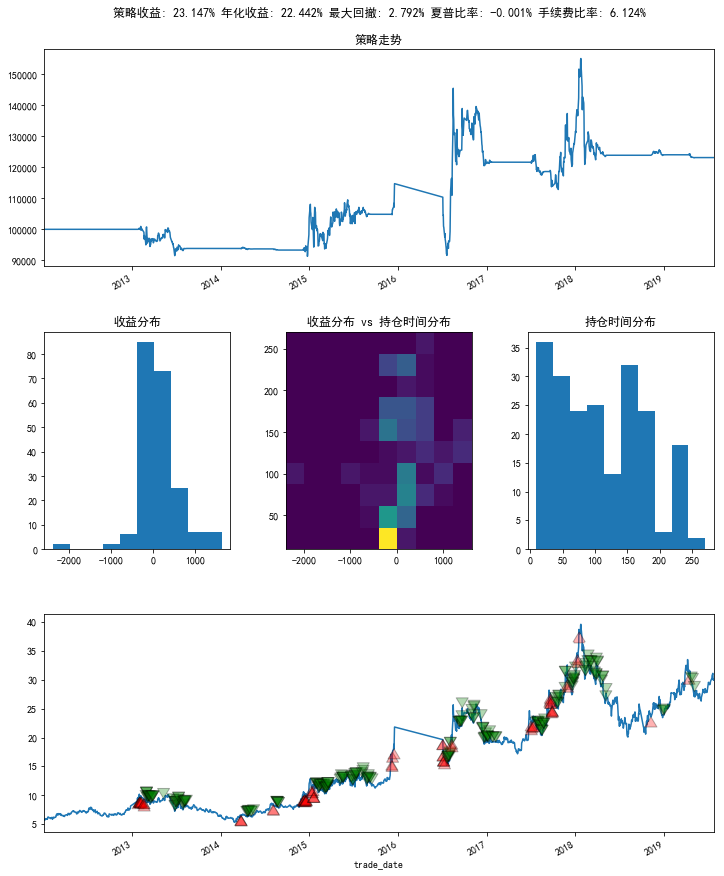

In [19]:
plotter = Plotter(feed, stat, order_lst)
plotter.report("report.png")

In [36]:
from bokeh.plotting import figure, output_notebook, show


p = figure(title="策略收益", plot_width=800, plot_height=250, x_axis_type="datetime")

p.line(stat.data.index, stat.data.assets_value, color='navy', alpha=0.5)

show(p)

In [44]:
from bokeh.plotting import gridplot
import numpy as np

p1 = figure(title="收益分布", plot_width=400, plot_height=300)
p2 = figure(title="持仓时间分布", plot_width=400, plot_height=300)

hist1, edges1 = np.histogram(profit_lst, bins=30)
hist2, edges2 = np.histogram(hold_time_lst, bins=30)

p1.quad(top=hist1, bottom=0, left=edges1[:-1], right=edges1[1:],
       fill_color="navy", line_color="white", alpha=0.5)

p2.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:],
       fill_color="navy", line_color="white", alpha=0.5)

show(gridplot([[p1, p2]]))
# show(p1)

In [72]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.layouts import row

# normal distribution center at x=0 and y=5
x = np.array(profit_lst)
y = np.array(hold_time_lst)

H, xe, ye = np.histogram2d(x, y, bins=10)

# produce an image of the 2d histogram
p = figure(x_range=(min(xe), max(xe)), y_range=(min(ye), max(ye)), title='Image')

p.image(image=[H], x=xe[0], y=ye[0], dw=xe[-1] - xe[0], dh=ye[-1] - ye[0], palette="Spectral11")

# produce hexbin plot
p2 = figure(title="Hexbin", match_aspect=True)
p.grid.visible = False

r, bins = p2.hex_tile(x, y, size=1, hover_color="pink", hover_alpha=0.8, palette='Spectral11')

show(row(p, p2))

AttributeError: unexpected attribute 'palette' to HexTile, possible attributes are aspect_scale, fill_alpha, fill_color, js_event_callbacks, js_property_callbacks, line_alpha, line_cap, line_color, line_dash, line_dash_offset, line_join, line_width, name, orientation, q, r, scale, size, subscribed_events or tags

In [79]:
import numpy as np

from bokeh.plotting import figure, show
from bokeh.layouts import row

# normal distribution center at x=0 and y=5
x = np.array(profit_lst)
y = np.array(hold_time_lst)

H, xe, ye = np.histogram2d(x, y, bins=30)

# produce an image of the 2d histogram
p = figure(x_range=(min(xe), max(xe)), y_range=(min(ye), max(ye)), title='Image')

p.image(image=[H], x=xe[0], y=ye[0], dw=xe[-1] - xe[0], dh=ye[-1] - ye[0], palette="Spectral11")

# produce hexbin plot
# p2 = figure(title="Hexbin", match_aspect=True)
# p.grid.visible = False

# r, bins = p2.hexbin(x, y, size=100, hover_color="pink", hover_alpha=0.8, palette='Spectral11')

show(p)

In [122]:
from bokeh.plotting import figure, show, output_file
from math import pi

reset_output()
output_notebook()

df = feed["000002.SZ"]
df["date"] = pd.to_datetime(df.index)

inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df.date, df.high, df.date, df.low, color="black")
p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")


# 绘制持仓股票走势图
for idx, code in enumerate([1], start=22):
    for order in order_lst:
        if len(order["deal_lst"]) == 0:
            continue
        if order["type"] == "buy":
            for deal in order["deal_lst"]:
                x, y = pd.to_datetime(deal["date"]), deal["price"]
                p.add_layout(Arrow(end=NormalHead(fill_color="red", fill_alpha=0.3, line_width=0, size=15), x_end=x, y_end=y, line_alpha=0, x_start=x, y_start=y + 10))


        if order["type"] == "sell":
            for deal in order["deal_lst"]:
                p.add_layout(Arrow(end=NormalHead(fill_color="green", fill_alpha=0.3, line_width=0, size=15), x_end=x, y_end=y, line_alpha=0, x_start=x, y_start=y - 10))
# output_file("candlestick.html", title="candlestick.py example")

print(type(x))
show(p)  # open a browser

Loading BokehJS ...

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [111]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead
from bokeh.plotting import figure, show, output_notebook, reset_output

reset_output()
output_notebook()

# output_file("arrow.html", title="arrow.py example")

p = figure(plot_width=600, plot_height=600)

p.circle(x=[0, 1, 0.5], y=[0, 0, 0.7], radius=0.1,
         color=["navy", "yellow", "red"], fill_alpha=0.1)

p.add_layout(Arrow(end=NormalHead(fill_color="green", fill_alpha=0.3, line_width=0, size=100), x_end=0.5, y_end=0.7, line_alpha=0, x_start=0.5, y_start=1))

show(p)

Loading BokehJS ...